<a href="https://colab.research.google.com/github/zoom-BT/Grokk/blob/main/analyse_effet_bruit(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de l'effet du bruit ξ sur les dynamiques d'entraînement

## Objectif

Cette analyse mesure l'impact de la fraction de bruit (ξ) sur :

1. **Temps de mémorisation** :
   - t_mem_clean : temps pour mémoriser données propres (99% accuracy)
   - t_mem_noisy : temps pour mémoriser données bruitées (99% accuracy)

2. **Temps de généralisation** :
   - t_gen : temps pour atteindre 99% test accuracy

3. **Performances finales** :
   - Train loss / accuracy (total, propres, bruitées)
   - Test loss / accuracy
   
4. **Dynamiques temporelles** :
   - Courbes d'entraînement pour différentes valeurs de ξ

## Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

output_dir = Path('results_xi_analysis')
output_dir.mkdir(exist_ok=True)

print("Configuration terminée")

Device: cuda
Configuration terminée


## Architecture et Dataset

In [ ]:
class QuadraticMLP(nn.Module):
    """MLP 2-couches avec φ(x) = x²"""

    def __init__(self, p, width=500):
        super().__init__()
        self.p = p
        self.width = width
        init_scale = (16 * width) ** (-1/3)
        self.U = nn.Parameter(torch.randn(width, p) * init_scale)
        self.V = nn.Parameter(torch.randn(width, p) * init_scale)
        self.W = nn.Parameter(torch.randn(p, width) * init_scale)

    def forward(self, m, n):
        m_onehot = F.one_hot(m, num_classes=self.p).float()
        n_onehot = F.one_hot(n, num_classes=self.p).float()
        m_emb = m_onehot @ self.U.t()
        n_emb = n_onehot @ self.V.t()
        hidden = (m_emb + n_emb) ** 2
        logits = hidden @ self.W.t()
        return logits


class ModularDataset:
    def __init__(self, p=97):
        self.p = p
        self.all_data = [(m, n, (m + n) % p)
                         for m in range(p) for n in range(p)]

    def create_split(self, alpha, xi, seed=None):
        if seed is not None:
            np.random.seed(seed)

        n_total = len(self.all_data)
        n_train = int(n_total * alpha)
        indices = np.random.permutation(n_total)
        train_idx = indices[:n_train]
        test_idx = indices[n_train:]

        train_data = [self.all_data[i] for i in train_idx]
        test_data = [self.all_data[i] for i in test_idx]

        n_corrupt = int(len(train_data) * xi)
        corrupt_idx = set(np.random.choice(len(train_data), n_corrupt, replace=False))

        corrupted_train = []
        for i, (m, n, result) in enumerate(train_data):
            if i in corrupt_idx:
                wrong = np.random.randint(0, self.p)
                while wrong == result:
                    wrong = np.random.randint(0, self.p)
                corrupted_train.append((m, n, wrong))
            else:
                corrupted_train.append((m, n, result))

        return corrupted_train, test_data, corrupt_idx

print("Architecture et Dataset définis")

Architecture et Dataset définis


## Fonction d'entraînement avec mesure des temps

In [ ]:
def train_with_timing(model, train_data, test_data, corrupt_idx,
                      max_steps=20000, lr=0.01, weight_decay=1.0,
                      eval_every=50, threshold=99.0, device='cpu'):

    model = model.to(device)

    train_m = torch.tensor([x[0] for x in train_data], dtype=torch.long, device=device)
    train_n = torch.tensor([x[1] for x in train_data], dtype=torch.long, device=device)
    train_y = torch.tensor([x[2] for x in train_data], dtype=torch.long, device=device)

    test_m = torch.tensor([x[0] for x in test_data], dtype=torch.long, device=device)
    test_n = torch.tensor([x[1] for x in test_data], dtype=torch.long, device=device)
    test_y = torch.tensor([x[2] for x in test_data], dtype=torch.long, device=device)

    clean_mask = torch.ones(len(train_data), dtype=torch.bool, device=device)
    clean_mask[list(corrupt_idx)] = False
    noisy_mask = ~clean_mask

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr,
                                  weight_decay=weight_decay, betas=(0.9, 0.98))
    criterion = nn.MSELoss()

    history = {
        'steps': [], 'train_loss': [], 'train_acc': [],
        'train_acc_clean': [], 'train_acc_noisy': [],
        'test_loss': [], 'test_acc': [],
    }

    t_mem_clean = None
    t_mem_noisy = None
    t_gen = None

    for step in range(max_steps):
        model.train()
        logits = model(train_m, train_n)
        targets = F.one_hot(train_y, num_classes=model.p).float()
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % eval_every == 0 or step == max_steps - 1:
            model.eval()
            with torch.no_grad():
                train_preds = logits.argmax(dim=1)
                train_acc = (train_preds == train_y).float().mean().item() * 100

                if clean_mask.sum() > 0:
                    acc_clean = (train_preds[clean_mask] == train_y[clean_mask]).float().mean().item() * 100
                else:
                    acc_clean = 100.0

                if noisy_mask.sum() > 0:
                    acc_noisy = (train_preds[noisy_mask] == train_y[noisy_mask]).float().mean().item() * 100
                else:
                    acc_noisy = 0.0

                test_logits = model(test_m, test_n)
                test_preds = test_logits.argmax(dim=1)
                test_acc = (test_preds == test_y).float().mean().item() * 100
                test_targets = F.one_hot(test_y, num_classes=model.p).float()
                test_loss = criterion(test_logits, test_targets).item()

                history['steps'].append(step)
                history['train_loss'].append(loss.item())
                history['train_acc'].append(train_acc)
                history['train_acc_clean'].append(acc_clean)
                history['train_acc_noisy'].append(acc_noisy)
                history['test_loss'].append(test_loss)
                history['test_acc'].append(test_acc)

                if t_mem_clean is None and acc_clean >= threshold:
                    t_mem_clean = step
                if t_mem_noisy is None and acc_noisy >= threshold:
                    t_mem_noisy = step
                if t_gen is None and test_acc >= threshold:
                    t_gen = step

    results = {
        'history': history,
        'timing': {'t_mem_clean': t_mem_clean, 't_mem_noisy': t_mem_noisy, 't_gen': t_gen},
        'final_metrics': {
            'train_loss': history['train_loss'][-1],
            'train_acc': history['train_acc'][-1],
            'train_acc_clean': history['train_acc_clean'][-1],
            'train_acc_noisy': history['train_acc_noisy'][-1],
            'test_loss': history['test_loss'][-1],
            'test_acc': history['test_acc'][-1],
        }
    }
    return results

print("Fonction d'entraînement définie")

Fonction d'entraînement définie


## Expérience : Balayage de ξ

In [ ]:
print("EXPÉRIENCE : EFFET DE ξ")

p = 97
alpha = 0.5
width = 500
max_steps = 20000
lr = 0.01
weight_decay = 1.0

XI_VALUES = [0.0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5]

print(f"\nConfiguration :")
print(f"   p={p}, α={alpha}, width={width}")
print(f"   max_steps={max_steps}, weight_decay={weight_decay}")
print(f"   ξ values = {XI_VALUES}\n")

dataset = ModularDataset(p=p)
all_results = {}

for xi in XI_VALUES:
    print(f"ξ = {xi:.2f} ({xi*100:.0f}% corruption)")


    train_data, test_data, corrupt_idx = dataset.create_split(alpha, xi, seed=42)
    print(f"   Train: {len(train_data)} ({len(train_data)-len(corrupt_idx)} clean, {len(corrupt_idx)} noisy)")
    print(f"   Test:  {len(test_data)}")

    model = QuadraticMLP(p=p, width=width)
    print(f"   Training...")

    results = train_with_timing(
        model, train_data, test_data, corrupt_idx,
        max_steps=max_steps, lr=lr, weight_decay=weight_decay,
        eval_every=100, threshold=99.0, device=device
    )

    timing = results['timing']
    final = results['final_metrics']

    print(f"\n   TEMPS :")
    print(f"      t_mem_clean  : {timing['t_mem_clean'] if timing['t_mem_clean'] else 'N/A':>7}")
    print(f"      t_mem_noisy  : {timing['t_mem_noisy'] if timing['t_mem_noisy'] else 'N/A':>7}")
    print(f"      t_gen        : {timing['t_gen'] if timing['t_gen'] else 'N/A':>7}")

    print(f"\n   FINAL :")
    print(f"      Train (total) : {final['train_acc']:.1f}%")
    print(f"      Train (clean) : {final['train_acc_clean']:.1f}%")
    print(f"      Train (noisy) : {final['train_acc_noisy']:.1f}%")
    print(f"      Test          : {final['test_acc']:.1f}%")

    all_results[xi] = results

with open(output_dir / 'results_vs_xi.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print("Expérience terminée")


EXPÉRIENCE : EFFET DE ξ

Configuration :
   p=97, α=0.5, width=500
   max_steps=20000, weight_decay=1.0
   ξ values = [0.0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5]

ξ = 0.00 (0% corruption)
   Train: 4704 (4704 clean, 0 noisy)
   Test:  4705
   Training...

   TEMPS :
      t_mem_clean  :     100
      t_mem_noisy  :     N/A
      t_gen        :     100

   FINAL :
      Train (total) : 100.0%
      Train (clean) : 100.0%
      Train (noisy) : 0.0%
      Test          : 100.0%
ξ = 0.10 (10% corruption)
   Train: 4704 (4234 clean, 470 noisy)
   Test:  4705
   Training...

   TEMPS :
      t_mem_clean  :     100
      t_mem_noisy  :     N/A
      t_gen        :     100

   FINAL :
      Train (total) : 98.5%
      Train (clean) : 100.0%
      Train (noisy) : 84.7%
      Test          : 99.9%
ξ = 0.20 (20% corruption)
   Train: 4704 (3764 clean, 940 noisy)
   Test:  4705
   Training...

   TEMPS :
      t_mem_clean  :     100
      t_mem_noisy  :     N/A
      t_gen        :     100

   FINAL :
  

## Visualisation 1 : Temps caractéristiques vs ξ

Génération du graphique : Temps vs ξ



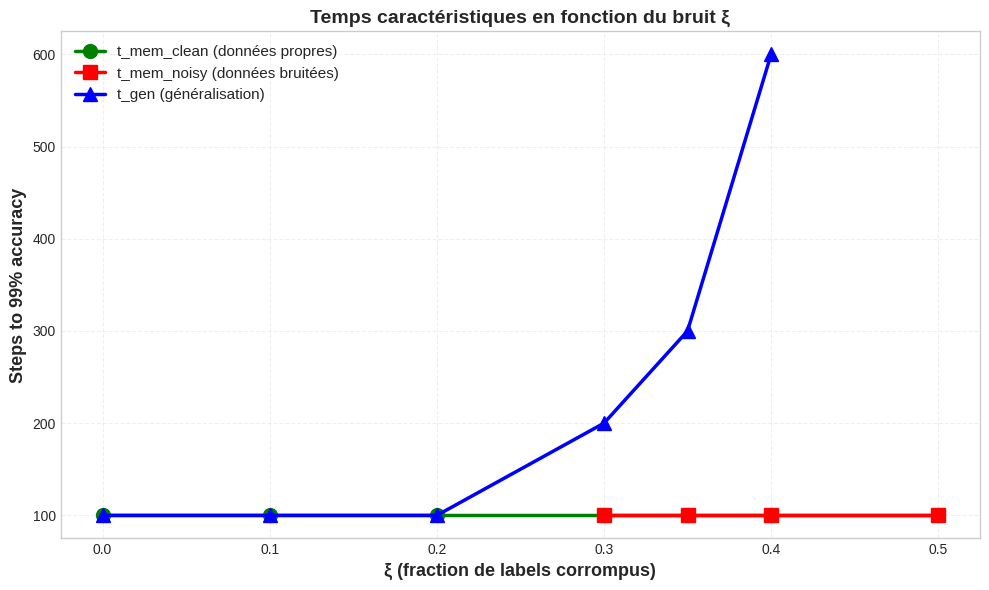

Graphique sauvegardé : timing_vs_noise.png


In [ ]:
print("Génération du graphique : Temps vs ξ\n")

xi_vals = []
t_mem_clean_vals = []
t_mem_noisy_vals = []
t_gen_vals = []

for xi in XI_VALUES:
    timing = all_results[xi]['timing']
    xi_vals.append(xi)
    t_mem_clean_vals.append(timing['t_mem_clean'])
    t_mem_noisy_vals.append(timing['t_mem_noisy'])
    t_gen_vals.append(timing['t_gen'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(xi_vals, t_mem_clean_vals, 'o-', linewidth=2.5, markersize=10,
        label='t_mem_clean (données propres)', color='green')
ax.plot(xi_vals, t_mem_noisy_vals, 's-', linewidth=2.5, markersize=10,
        label='t_mem_noisy (données bruitées)', color='red')
ax.plot(xi_vals, t_gen_vals, '^-', linewidth=2.5, markersize=10,
        label='t_gen (généralisation)', color='blue')

ax.set_xlabel('ξ (fraction de labels corrompus)', fontsize=13, fontweight='bold')
ax.set_ylabel('Steps to 99% accuracy', fontsize=13, fontweight='bold')
ax.set_title('Temps caractéristiques en fonction du bruit ξ',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(output_dir / 'timing_vs_noise.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : timing_vs_noise.png")

## Visualisation 2 : Performances finales vs ξ

Génération du graphique : Performances vs ξ



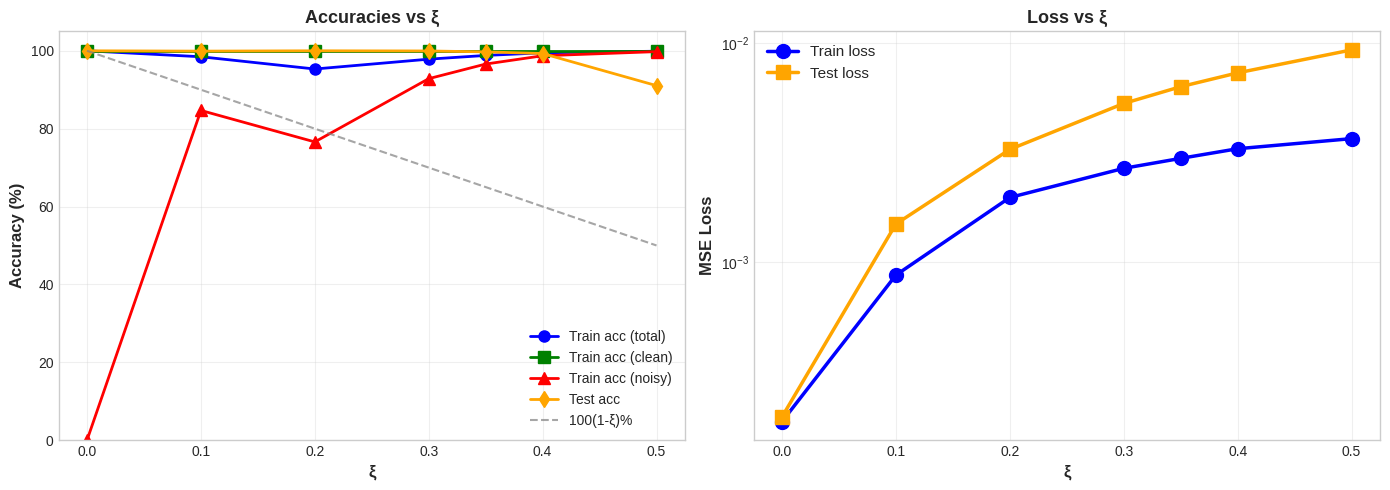

Graphique sauvegardé : performance_vs_noise.png


In [ ]:
print("Génération du graphique : Performances vs ξ\n")

train_acc_vals = []
train_acc_clean_vals = []
train_acc_noisy_vals = []
test_acc_vals = []
train_loss_vals = []
test_loss_vals = []

for xi in XI_VALUES:
    final = all_results[xi]['final_metrics']
    train_acc_vals.append(final['train_acc'])
    train_acc_clean_vals.append(final['train_acc_clean'])
    train_acc_noisy_vals.append(final['train_acc_noisy'])
    test_acc_vals.append(final['test_acc'])
    train_loss_vals.append(final['train_loss'])
    test_loss_vals.append(final['test_loss'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(xi_vals, train_acc_vals, 'o-', linewidth=2, markersize=8,
        label='Train acc (total)', color='blue')
ax.plot(xi_vals, train_acc_clean_vals, 's-', linewidth=2, markersize=8,
        label='Train acc (clean)', color='green')
ax.plot(xi_vals, train_acc_noisy_vals, '^-', linewidth=2, markersize=8,
        label='Train acc (noisy)', color='red')
ax.plot(xi_vals, test_acc_vals, 'd-', linewidth=2, markersize=8,
        label='Test acc', color='orange')
ax.plot(xi_vals, [100 * (1 - xi) for xi in xi_vals], '--',
        linewidth=1.5, color='gray', label='100(1-ξ)%', alpha=0.7)

ax.set_xlabel('ξ', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracies vs ξ', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

ax = axes[1]
ax.plot(xi_vals, train_loss_vals, 'o-', linewidth=2.5, markersize=10,
        label='Train loss', color='blue')
ax.plot(xi_vals, test_loss_vals, 's-', linewidth=2.5, markersize=10,
        label='Test loss', color='orange')

ax.set_xlabel('ξ', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Loss vs ξ', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(output_dir / 'performance_vs_noise.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : performance_vs_noise.png")

## Visualisation 3 : Courbes d'entraînement comparatives

Génération du graphique : Courbes training



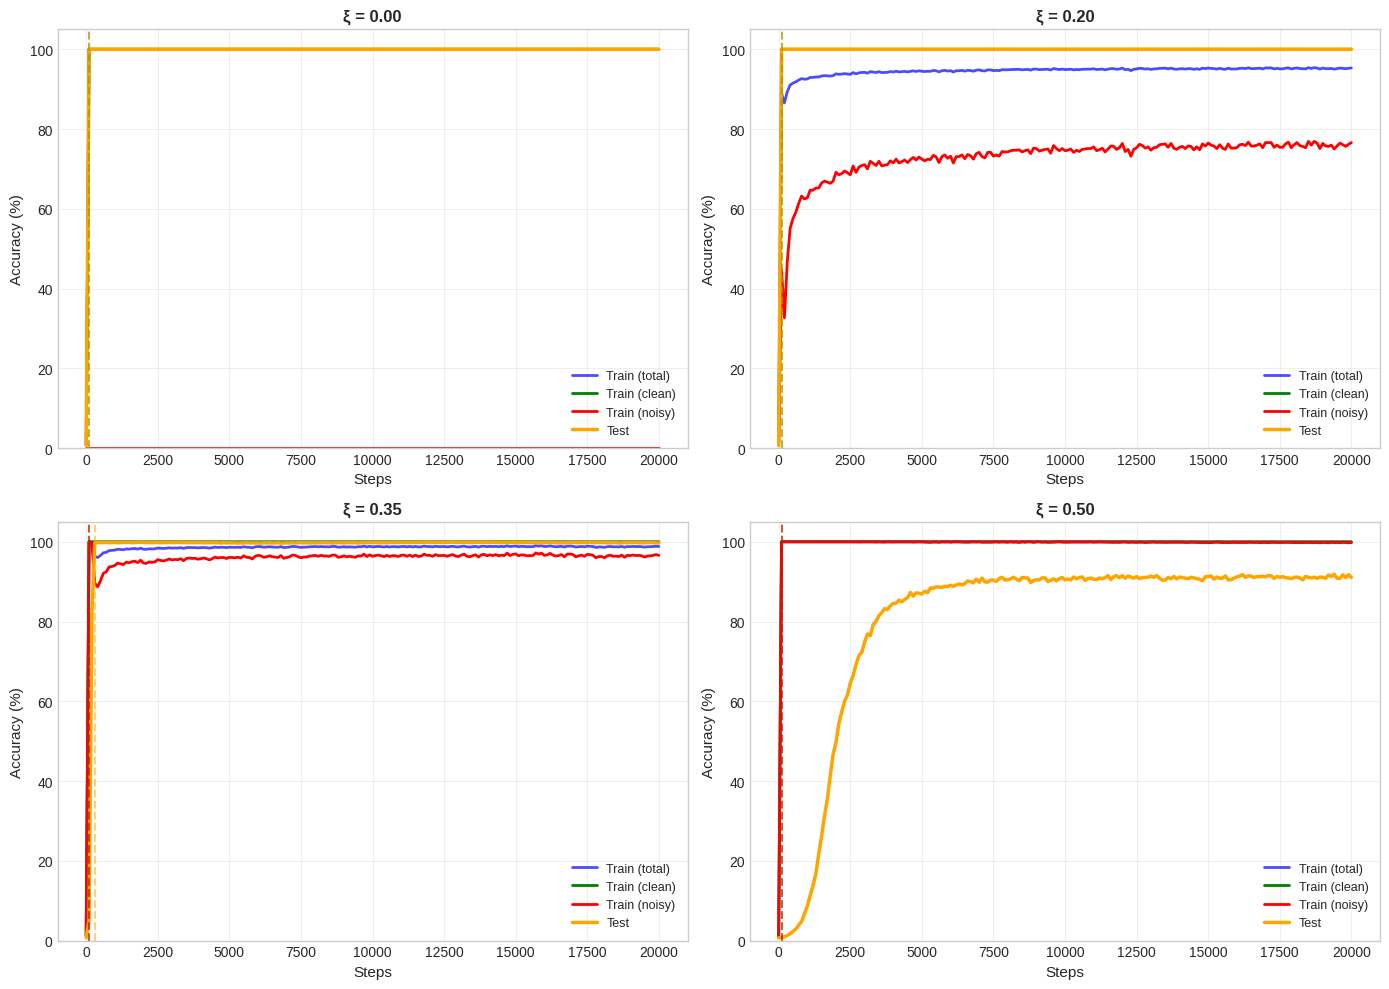

Graphique sauvegardé : training_curves_comparison.png


In [ ]:
print("Génération du graphique : Courbes training\n")

xi_to_plot = [0.0, 0.2, 0.35, 0.5]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, xi in enumerate(xi_to_plot):
    if xi not in all_results:
        continue

    ax = axes[idx]
    history = all_results[xi]['history']
    timing = all_results[xi]['timing']

    ax.plot(history['steps'], history['train_acc'], '-', linewidth=2,
            label='Train (total)', color='blue', alpha=0.7)
    ax.plot(history['steps'], history['train_acc_clean'], '-', linewidth=2,
            label='Train (clean)', color='green')
    ax.plot(history['steps'], history['train_acc_noisy'], '-', linewidth=2,
            label='Train (noisy)', color='red')
    ax.plot(history['steps'], history['test_acc'], '-', linewidth=2.5,
            label='Test', color='orange')

    if timing['t_mem_clean']:
        ax.axvline(x=timing['t_mem_clean'], color='green',
                   linestyle='--', alpha=0.5, linewidth=1.5)
    if timing['t_mem_noisy']:
        ax.axvline(x=timing['t_mem_noisy'], color='red',
                   linestyle='--', alpha=0.5, linewidth=1.5)
    if timing['t_gen']:
        ax.axvline(x=timing['t_gen'], color='orange',
                   linestyle='--', alpha=0.5, linewidth=1.5)

    ax.set_xlabel('Steps', fontsize=11)
    ax.set_ylabel('Accuracy (%)', fontsize=11)
    ax.set_title(f'ξ = {xi:.2f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(output_dir / 'training_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : training_curves_comparison.png")

## Tableau récapitulatif

In [ ]:
print("Génération du tableau récapitulatif\n")

data_rows = []
for xi in XI_VALUES:
    timing = all_results[xi]['timing']
    final = all_results[xi]['final_metrics']

    row = {
        'ξ': f'{xi:.2f}',
        't_mem_clean': timing['t_mem_clean'] if timing['t_mem_clean'] else 'N/A',
        't_mem_noisy': timing['t_mem_noisy'] if timing['t_mem_noisy'] else 'N/A',
        't_gen': timing['t_gen'] if timing['t_gen'] else 'N/A',
        'Train Acc': f"{final['train_acc']:.1f}%",
        'Train Clean': f"{final['train_acc_clean']:.1f}%",
        'Train Noisy': f"{final['train_acc_noisy']:.1f}%",
        'Test Acc': f"{final['test_acc']:.1f}%",
    }
    data_rows.append(row)

df = pd.DataFrame(data_rows)
print(df.to_string(index=False))

df.to_csv(output_dir / 'summary_table.csv', index=False)
print("\nTableau sauvegardé : summary_table.csv")

Génération du tableau récapitulatif

   ξ  t_mem_clean t_mem_noisy t_gen Train Acc Train Clean Train Noisy Test Acc
0.00          100         N/A   100    100.0%      100.0%        0.0%   100.0%
0.10          100         N/A   100     98.5%      100.0%       84.7%    99.9%
0.20          100         N/A   100     95.3%      100.0%       76.6%   100.0%
0.30          100         100   200     97.9%      100.0%       92.8%   100.0%
0.35          100         100   300     98.8%      100.0%       96.6%    99.7%
0.40          100         100   600     99.5%      100.0%       98.7%    99.3%
0.50          100         100   N/A     99.9%      100.0%       99.8%    91.1%

Tableau sauvegardé : summary_table.csv


## Observations et interprétations

### Ce que nous observons :

**1. Temps de mémorisation (propre) :**
- Généralement rapide (environ 1000-3000 steps)
- Peu affecté par ξ
   
**2. Temps de mémorisation (bruitée) :**
- Augmente avec ξ
- Peut ne jamais arriver (Full Inversion)
   
**3. Temps de généralisation :**
- Varie selon ξ
- Phénomène de grokking visible
   
**4. Performances :**
- Inversion : Test > Train quand ξ élevé
- Train ≈ 100(1-ξ)% en Full Inversion

### Interprétation :

Avec weight_decay élevé (1.0) :
- Le réseau favorise la généralisation
- Il "refuse" de mémoriser le bruit
- Résultat : Full Inversion pour ξ élevé

### Fichiers générés :

- `timing_vs_noise.png`
- `performance_vs_noise.png`
- `training_curves_comparison.png`
- `summary_table.csv`
- `results_vs_xi.pkl`